In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
import warnings
warnings.filterwarnings('ignore')
import geopandas as gp
from shapely.geometry import Point, Polygon

In [36]:
raw = pd.read_csv('1_ProcessedData/rawData.csv')
myData = pd.read_csv('1_ProcessedData/data4prediction.csv')

# Process myData

In [51]:
myData = myData.loc[:,('device_id', 'gender', 'age', 'group', 'phone_brand', 'events_holi_day', 'events_holi_night',
                    'events_work_day', 'events_work_night', 'categories_total', 'education', 'entertainment',
                    'finance', 'game', 'health', 'life', 'news', 'shopping', 'social', 'tools', 'travel')]
myData2 = myData.copy()

In [56]:
# transfer app percents to app nums
myData2.iloc[:,10:] = myData.iloc[:,9:].apply(lambda x: x[0] * x[1:], axis=1).apply(np.round, args=0)

In [23]:
events_df = raw.sort_values(
    by='device_id',
    ignore_index=True).loc[:, ('device_id',
                               'event_id')].drop_duplicates(subset='event_id',
                                                            keep='first')
events_count = pd.DataFrame(events_df.groupby('device_id').size()).reset_index().rename(columns={0:'events_total'})

In [58]:
# transfer event percents to event nums
myData2 = pd.merge(myData2, events_count, how='left', on='device_id')
myData2.iloc[:, 5:9] = pd.concat((myData2.events_total, myData.iloc[:, 5:9]),
                                 axis=1).apply(lambda x: x[0] * x[1:],
                                               axis=1).apply(np.round, args=0)

In [64]:
brand_df = pd.DataFrame(
    myData2.groupby('phone_brand').size()).reset_index().rename(
        columns={
            0: 'brand_count'
        }).sort_values('brand_count', ascending=False, ignore_index=True)

In [ ]:
brand_df['brand_factor'] = list(range(9)) + [9] * (brand_df.shape[0]-9)
brand_df.to_excel('1_ProcessedData/brand2factor.xlsx', index=False)

In [81]:
# transfer brand names to brand factors
myData2['brand'] = myData2['phone_brand'].map(brand_df.set_index(['phone_brand'])['brand_factor'].to_dict())

In [88]:
def transGroup(series):
    gender = series[0]
    age = series[1]
    
    if gender == 0:
        if age <= 30:
            return 0
        else:
            return 1
    else:
        if age <= 30:
            return 2
        else:
            return 3

In [90]:
# transfer group to group factors
# 0 = M30-, 1 = M31+, 2 = F30-, 3=F31+
myData2['group'] = myData2.loc[:,('gender', 'age')].apply(transGroup, axis=1)
myData2.groupby('group').size()

group
0    1457
1    1773
2     574
3     651
dtype: int64

In [283]:
myData_final = myData2.drop(['age', 'phone_brand', 'categories_total', 'events_total'], axis=1)

In [284]:
myData_final.iloc[:,3:18] = myData_final.iloc[:,3:18].apply(np.int64)

In [285]:
# age group: 0 = 30-, 1 = 31+
myData_final.insert(2, 'age', myData_final['group'].apply(lambda x:0 if x in (0,2) else 1))

In [286]:
myData_final.rename(
    columns={
        'events_holi_day': 'restDay',
        'events_holi_night': 'restNight',
        'events_work_day': 'workDay',
        'events_work_night': 'workNight'
    }, inplace=True)
myData_final

,device_id,gender,age,group,restDay,restNight,workDay,workNight,education,entertainment,finance,game,health,life,news,shopping,social,tools,travel,brand
0,-9217193238265898015,0,1,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,5
1,-9212412905070443687,0,1,1,1,6,2,9,0,0,0,36,0,18,0,0,0,0,0,4
2,-9201434269962947628,0,1,1,0,3,1,3,0,7,7,7,0,0,0,0,0,0,0,1
3,-9198513807097378193,0,0,0,0,2,4,0,0,0,0,0,0,0,0,0,0,6,0,6
4,-9192503757087427819,0,1,1,4,6,11,0,0,0,21,21,0,0,21,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4450,9207229814361457203,1,0,2,0,3,0,3,0,0,0,12,0,0,0,0,0,0,6,3
4451,9207308632673862076,1,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4452,9216925254504446539,0,1,1,17,13,7,5,0,0,42,42,0,0,42,0,0,0,0,0
4453,9219164468944552013,0,1,1,45,51,60,66,0,0,2886,0,0,0,0,0,0,262,0,0


# Get Locations of Each User

In [104]:
raw = raw.sort_values(by='device_id', ignore_index=True)

In [110]:
location_raw = raw.loc[:,('device_id', 'longitude', 'latitude')]
myLocation = pd.DataFrame(columns=('device_id', 'longitude', 'latitude'))
myLocation['device_id'] = myData_final['device_id']

In [129]:
for i in range(len(myLocation)):
    devID = myLocation['device_id'][i]
    loc_oneID = location_raw[location_raw['device_id']==devID]
    
    if len(loc_oneID[loc_oneID['longitude'].isin([0,1])]) == len(loc_oneID):
        continue
    
    myLocation.iloc[i,1:3] = loc_oneID[loc_oneID['longitude'].isin([0,1])==False].iloc[0,1:3]

myLocation

,device_id,longitude,latitude
0,-9217193238265898015,NaN,NaN
1,-9212412905070443687,NaN,NaN
2,-9201434269962947628,NaN,NaN
3,-9198513807097378193,NaN,NaN
4,-9192503757087427819,119.04,25.49
...,...,...,...
4450,9207229814361457203,NaN,NaN
4451,9207308632673862076,NaN,NaN
4452,9216925254504446539,120.56,31.32
4453,9219164468944552013,120.15,30.23


In [134]:
len(myLocation[myLocation['longitude'].isna()])

2211

In [154]:
china_map=gp.GeoDataFrame.from_file('china_shp/chn_admbnda_adm1_ocha_2020.shp')

In [168]:
myLoc_draw = myLocation.dropna()
myLoc_draw = myLoc_draw.loc[(myLoc_draw['longitude'] > 70)
                            & (myLoc_draw['longitude'] < 135) &
                            (myLoc_draw['latitude'] > 15)]
lng = myLoc_draw['longitude']
lat = myLoc_draw['latitude']

<AxesSubplot:>

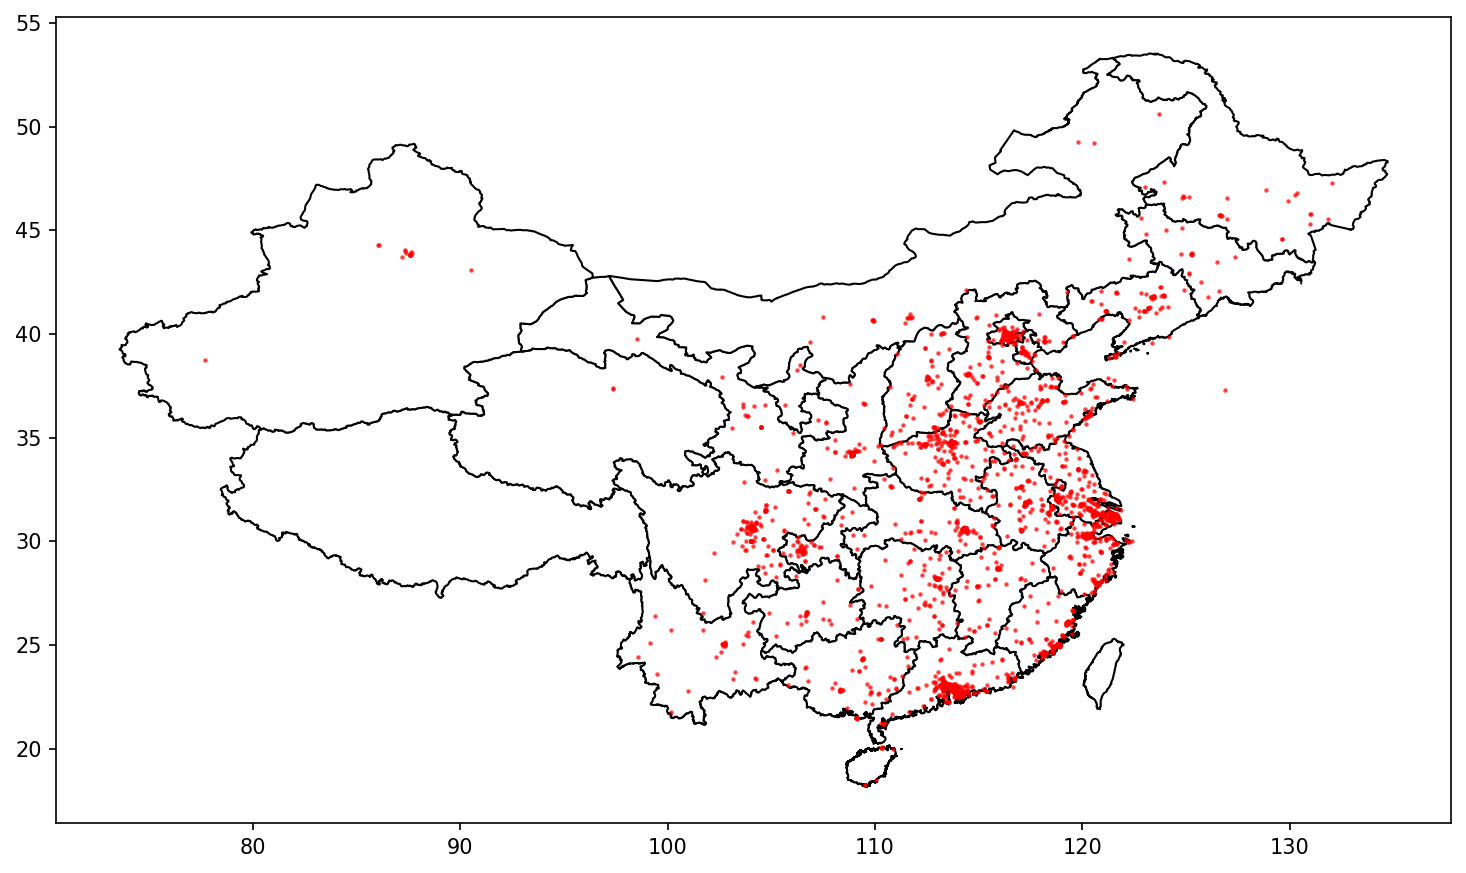

In [185]:
# 几何图形
geo_ploy = china_map['geometry']
# 地图点
geo_point = gp.GeoSeries([Point(x, y) for x, y in zip(lng, lat)])
 
fig, ax = plt.subplots(figsize=(12,12))
 
ax.set_aspect(1.5)
# 几何图形绘制
geo_ploy.plot(ax=ax, color='white', edgecolor='black')
 
# 地图点标注
geo_point.plot(ax=ax, marker='o', color='red', markersize=1.5, alpha=0.6)

In [181]:
fig.savefig('2_figures/china.png')

In [194]:
polys = geopandas.GeoSeries(china_map.set_index(['ADM1_ZH'])['geometry'].to_dict())
_pnts = list(myLoc_draw.loc[:, ('longitude', 'latitude')].apply(lambda x: Point(x[0], x[1]), axis=1))
pnts = gp.GeoDataFrame(geometry=_pnts, index=myLoc_draw['device_id'])

In [ ]:
pnts_in_polys = pnts.assign(**{key: pnts.within(geom) for key, geom in polys.items()})

In [216]:
pd.DataFrame(pnts_in_polys.iloc[:,1:].apply(np.sum, axis=1)).groupby(0).size()

0
0      50
1    2177
dtype: int64

In [237]:
pnts_in_polys['truePos'] = pnts_in_polys.apply(lambda x: list(x).index(True)
                                               if np.sum(x[1:]) == 1 else -1,
                                               axis=1)
pnts_in_polys['geoPos'] = pnts_in_polys['truePos'].apply(
    lambda x: list(pnts_in_polys.columns[:-1])[x] if x != -1 else 0)

In [262]:
myGeos = pd.DataFrame(pnts_in_polys.groupby('geoPos').size()).sort_values(
    0, ascending=False).reset_index().rename(columns={0: 'geoCount'})
myGeos = myGeos.drop(16,axis=0).reset_index(drop=True)
myGeos['geoLabel'] = list(range(15)) + [15] * (len(myGeos)-15)
myGeos.to_excel('1_ProcessedData/myGeoLabels.xlsx', index=False)
myGeos

,geoPos,geoCount,geoLabel
0,广东省,243,0
1,江苏省,192,1
2,河南省,162,2
3,四川省,159,3
4,北京市,137,4
5,安徽省,125,5
6,浙江省,124,6
7,山东省,110,7
8,湖北省,95,8
9,上海市,91,9


In [272]:
geo_final = pnts_in_polys[pnts_in_polys['geoPos']!=0].reset_index().loc[:,('device_id', 'geoPos')]
geo_final['geoLabel'] = geo_final['geoPos'].map(myGeos.set_index(['geoPos'])['geoLabel'].to_dict())

In [290]:
myData_final_geo = pd.merge(myData_final, geo_final.loc[:,('device_id', 'geoLabel')], how='left', on='device_id')
myData_final_geo['geoLabel'] = myData_final_geo['geoLabel'].fillna(-1)

In [291]:
myData_final_geo

,device_id,gender,age,group,restDay,restNight,workDay,workNight,education,entertainment,...,game,health,life,news,shopping,social,tools,travel,brand,geoLabel
0,-9217193238265898015,0,1,1,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,5,-1.0
1,-9212412905070443687,0,1,1,1,6,2,9,0,0,...,36,0,18,0,0,0,0,0,4,-1.0
2,-9201434269962947628,0,1,1,0,3,1,3,0,7,...,7,0,0,0,0,0,0,0,1,-1.0
3,-9198513807097378193,0,0,0,0,2,4,0,0,0,...,0,0,0,0,0,0,6,0,6,-1.0
4,-9192503757087427819,0,1,1,4,6,11,0,0,0,...,21,0,0,21,0,0,0,0,7,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4450,9207229814361457203,1,0,2,0,3,0,3,0,0,...,12,0,0,0,0,0,0,6,3,-1.0
4451,9207308632673862076,1,0,2,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,-1.0
4452,9216925254504446539,0,1,1,17,13,7,5,0,0,...,42,0,0,42,0,0,0,0,0,1.0
4453,9219164468944552013,0,1,1,45,51,60,66,0,0,...,0,0,0,0,0,0,262,0,0,6.0


In [292]:
myData_final_geo.to_csv('1_ProcessedData/final_data.csv', index=False)

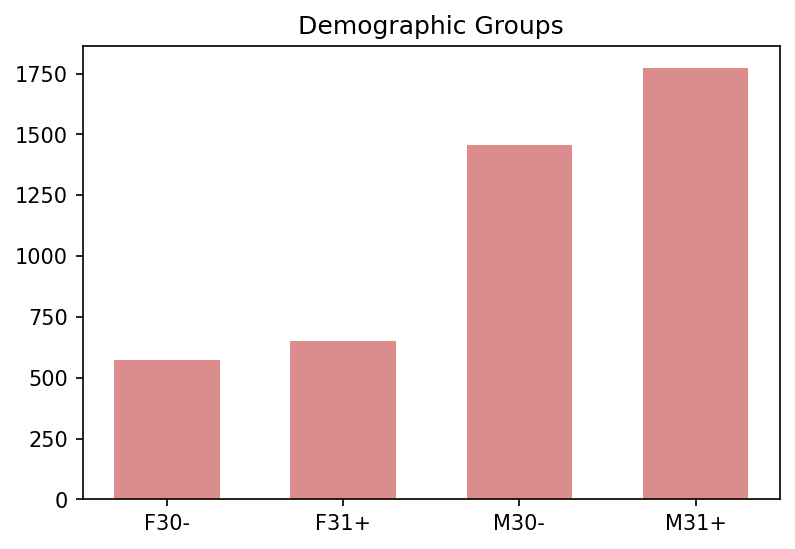

In [299]:
myData_final_geo['groupName'] = myData_final_geo['group'].map({0:'M30-',1:'M31+',2:'F30-',3:'F31+'})
groupID = myData_final_geo.groupby('groupName').size().index
groupNum = myData_final_geo.groupby('groupName').size()

plt.bar(groupID, groupNum, color='#c53f3f', width=0.6, alpha=0.6)
plt.xticks(size=10)
plt.yticks(size=10)
plt.title('Demographic Groups')
plt.savefig('2_figures/demo_bar.png')

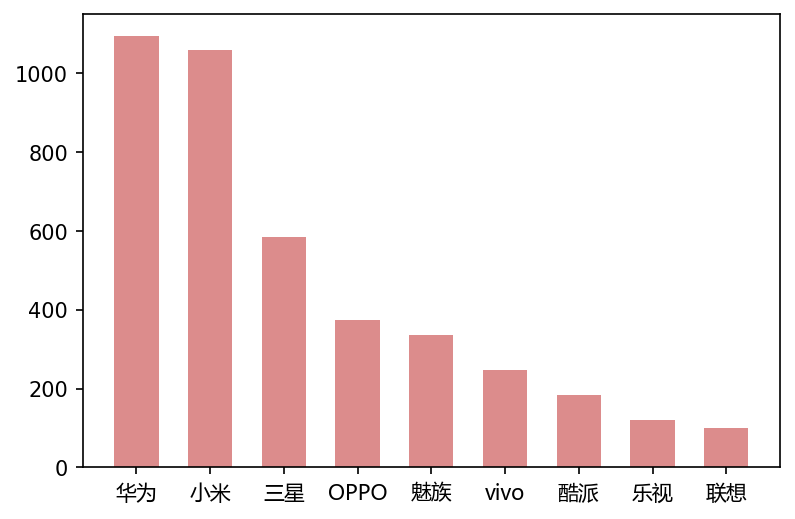

In [303]:
brandID = pd.DataFrame(myData2.groupby('phone_brand').size()).sort_values(by=0, ascending=False).index[:9]
brandNum = pd.DataFrame(myData2.groupby('phone_brand').size()).sort_values(by=0, ascending=False)[0][:9]

import matplotlib.font_manager as fm
myfont = fm.FontProperties(fname='C:\Windows\Fonts\msyh.ttc')

plt.bar(brandID, brandNum, color='#c53f3f', width=0.6, alpha=0.6)
plt.xticks(size=10,fontproperties=myfont)
plt.yticks(size=10)
plt.savefig('2_figures/brand_bar.png')

In [301]:
pd.DataFrame(myData2.groupby('phone_brand').size())

,0
phone_brand,
HTC,20
LG,9
OPPO,373
TCL,9
ZUK,29
vivo,246
一加,13
三星,585
中兴,54


# Split Dataset

In [293]:
def split_train(data,test_ratio):
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data)*test_ratio)
    test_indices =shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]

In [294]:
np.random.seed(1234)
train, validation = split_train(myData_final_geo, test_ratio=0.2)
train.to_csv('1_ProcessedData/train3.csv', index=False, encoding='utf-8')
validation.to_csv('1_ProcessedData/validation3.csv', index=False, encoding='utf-8')